**Remarks**

In this notebook, we weill learn about spam-messaging-classification. I used this dataset to analyze (check: https://www.kaggle.com/uciml/sms-spam-collection-dataset). Let's started!

In [53]:
# importing libraries
# 1. NLP tools
import re 
import string
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# 2. Preprocessing tools
import numpy as np
import pandas as pd

# 3. Modelling tools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

# 4. Visualization tools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
# !pip install --upgrade plotly

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [21]:
# loading dataset
data = pd.read_csv('../content/spam-kaggle.csv',sep=',',names=['label','message'], encoding='ISO-8859-1')
data.reset_index(inplace=True)
data = data.drop(['label', 'level_2', 'message'], axis=1)
data = data.rename(columns={'level_0':'label',
                            'level_1':'message'})
data = data.drop([0], axis=0)
data.head()

,label,message
1,ham,"Go until jurong point, crazy.. Available only ..."
2,ham,Ok lar... Joking wif u oni...
3,spam,Free entry in 2 a wkly comp to win FA Cup fina...
4,ham,U dun say so early hor... U c already then say...
5,ham,"Nah I don't think he goes to usf, he lives aro..."


In [22]:
# checking number of ham and spam
data.label.value_counts()

ham     4825
spam     747
Name: label, dtype: int64

In [23]:
data.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

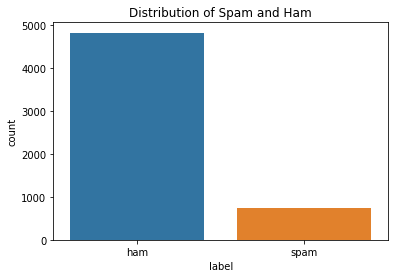

In [24]:
# plotting distribution
sns.countplot(x='label', data=data)
data.loc[:, 'label'].value_counts()
plt.title('Distribution of Spam and Ham');

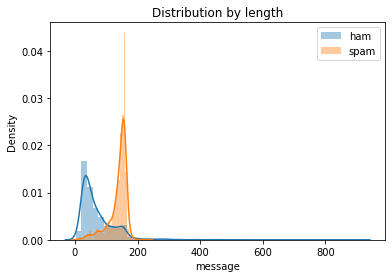

In [25]:
# distribution graph by length
ham = data[data['label'] == 'ham']['message'].str.len()
spam = data[data['label'] == 'spam']['message'].str.len()
sns.distplot(ham, label='ham')
sns.distplot(spam, label='spam')
plt.title('Distribution by length')
plt.legend();

In [26]:
# checking most common words
from collections import Counter

count_data_ham = Counter(" ".join(data[data['label']=='ham']['message']).split()).most_common(30)
info_data_ham = pd.DataFrame.from_dict(count_data_ham)
info_data_ham = info_data_ham.rename(columns={0: "words of ham", 1 : "count"})
count_data_spam = Counter(" ".join(data[data['label']=='spam']['message']).split()).most_common(30)
info_data_spam = pd.DataFrame.from_dict(count_data_spam)
info_data_spam = info_data_spam.rename(columns={0: "words of spam", 1 : "count"})

In [27]:
# showing graph common words -- SPAM
fig = px.treemap(info_data_spam, path=['words of spam'], values='count',title='Tree of Most Common Words SPAM')
fig.show()

In [28]:
# showing graph common words -- SPAM
fig = px.treemap(info_data_ham, path=['words of ham'], values='count',title='Tree of Most Common Words HAM')
fig.show()

In [10]:
# cleaning data, dropping stopwords, and lemmatization
lemmatizer = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))

In [11]:
def alternative_review_messages(msg):
  msg = msg.lower()
  nltk_pos = [tag[1] for tag in pos_tag(word_tokenize(msg))]
  msg = [tag[0] for tag in pos_tag(word_tokenize(msg))]
  wnpos = ['a' if tag[0] == 'J' else tag[0].lower() if tag[0] in ['N', 'R', 'V'] else 'n' for tag in nltk_pos]
  msg = " ".join([lemmatizer.lemmatize(word, wnpos[i]) for i, word in enumerate(msg)])
  # removing stopwords 
  msg = [word for word in msg.split() if word not in stopwords]
  
  return msg

In [12]:
data['message'] = data['message'].apply(alternative_review_messages)

In [13]:
data.head()

,label,message
1,ham,"[go, jurong, point, ,, crazy.., available, bug..."
2,ham,"[ok, lar, ..., joke, wif, u, oni, ...]"
3,spam,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
4,ham,"[u, dun, say, early, hor, ..., u, c, already, ..."
5,ham,"[nah, n't, think, go, usf, ,, live, around, th..."


In [29]:
X = data.message
y = data.label

In [48]:
# vectorizing the text
# 1. splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# 2. training vectorizer
vectorizer = TfidfVectorizer()
# NOTE
# analyzer='word', binary=False, decode_error='ignore',
# encoding=u'utf-8', input=u'content', lowercase=True,
# max_df=0.25, max_features=None, min_df=1, ngram_range=(1, 1),
# norm=u'l2', preprocessor=None, smooth_idf=True,
# stop_words='english', strip_accents=None,
# sublinear_tf=True, token_pattern=u'(?u)\\b\\w\\w+\\b'
X_train = vectorizer.fit_transform(X_train)
# X_train = TfidfTransformer().fit_transform(X_train)

In [68]:
spam_detect_model = MultinomialNB(alpha=1.0).fit(X_train, y_train)

In [69]:
X_test = vectorizer.transform(X_test)
y_pred = spam_detect_model.predict(X_test)

In [54]:
# checking accuracy
print("Confusion Matrix")
print(confusion_matrix(y_test, y_pred))
print()
print("Accuracy Score {}%".format(round((accuracy_score(y_test,y_pred)*100),2)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

Confusion Matrix
[[491   0]
 [ 15  52]]

Accuracy Score 97.31%
Classification report:               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       491
        spam       1.00      0.78      0.87        67

    accuracy                           0.97       558
   macro avg       0.99      0.89      0.93       558
weighted avg       0.97      0.97      0.97       558



In [71]:
# checking accuracy alpha = 1.0
print("Accuracy Score {}%".format(round((accuracy_score(y_test,y_pred)*100),2)))
print("Classification report: {}".format(classification_report(y_test,y_pred)))

Accuracy Score 97.49%
Classification report:               precision    recall  f1-score   support

         ham       0.97      1.00      0.99       491
        spam       1.00      0.79      0.88        67

    accuracy                           0.97       558
   macro avg       0.99      0.90      0.93       558
weighted avg       0.98      0.97      0.97       558



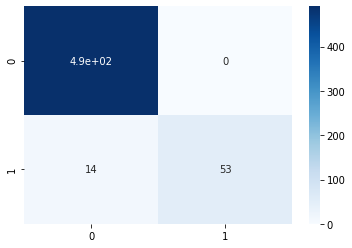

In [73]:
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, cmap='Blues');

In [74]:
# Trying new messages
def pred(msg):
  msg = vectorizer.transform([msg])
  prediction = spam_detect_model.predict(msg)
  return prediction[0]

In [75]:
pred("I love to watch BTS meal in McD")

'ham'

In [76]:
pred("Elon musk on the ways to the moon")

'ham'

In [82]:
pred("Free ticket in a comp to win FA Cup final")

'spam'